In [2]:
# Librerias del ambiente de entorno 
import os
import warnings
warnings.filterwarnings("ignore")
from dotenv import load_dotenv, find_dotenv 

from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults 
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from IPython.display import Image, display 
from dotenv import load_dotenv
from langchain_experimental.tools import PythonREPLTool

# Libreria del modelo llm
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

#from langchain_openai import ChatOpenAI
#llm = ChatOpenAI(model="gpt-4o")

# Credenciales de api del llm de google 
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

# Credenciales de api Tavity
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

# Define the llm 
llm =  ChatGoogleGenerativeAI (model="gemini-2.0-flash", temperature=0) 

tavily_search = TavilySearchResults(max_results=2)

python_repl_tool = PythonREPLTool()

#print(tavily_search.invoke("que es una disciplina")[0]["content"])

In [3]:
python_repl_tool.invoke("x = 5; print(x)")


Python REPL can execute arbitrary code. Use with caution.


'5\n'

In [4]:
class Supervisor(BaseModel):
    next: Literal["enhancer", "researcher", "coder"] = Field(
        description="Determina qué especialista activar a continuación en la secuencia del flujo de trabajo:"
                    "'enhancer' cuando la entrada del usuario requiere clarificación, expansión o refinamiento,"
                    "'researcher' cuando se necesitan hechos, contexto o recopilación de datos adicionales,"
                    "'coder' cuando se requiere implementación, computación o resolución de problemas técnicos."
    )
    reason: str = Field(
        description="Justificación detallada de la decisión de enrutamiento, explicando la lógica detrás de la selección del especialista en particular y cómo esto hace avanzar la tarea hacia su finalización."
    )

def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:
    system_prompt = ('''
    **Miembros del Equipo**:
        1. **Prompt Enhancer**: Siempre considera a este agente primero. Clarifica solicitudes ambiguas, mejora consultas mal definidas y asegura que la tarea esté bien estructurada antes de que comience un procesamiento más profundo.
        2. **Researcher**: Se especializa en la recopilación de información, la búsqueda de hechos y la recolección de datos relevantes necesarios para abordar la solicitud del usuario.
        3. **Coder**: Se centra en la implementación técnica, los cálculos, el análisis de datos, el desarrollo de algoritmos y las soluciones de codificación.

    **Tus Responsabilidades**:
        1. Analiza cada solicitud del usuario y respuesta del agente en cuanto a integridad, precisión y relevancia.
        2. Dirige la tarea al agente más apropiado en cada punto de decisión.
        3. Mantiene el impulso del flujo de trabajo evitando asignaciones de agentes redundantes.
        4. Continúa el proceso hasta que la solicitud del usuario esté completa y satisfactoriamente resuelta.

    Tu objetivo es crear un flujo de trabajo eficiente que aproveche las fortalezas de cada agente mientras minimiza los pasos innecesarios, entregando en última instancia soluciones completas y precisas a las solicitudes de los usuarios.         
                 
    ''')
    
    # Se construyen los mensajes del flujo
    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"] 


    # Se invoca el modelo con salida estructurada
    response = llm.with_structured_output(Supervisor).invoke(messages)

    # Se extrae el resultado
    goto = response.next
    reason = response.reason

    # Se imprime la transición del flujo
    print(f"--- Transición del Flujo de Trabajo: Supervisor → {goto.upper()} ---")
    
    return Command(
        update={
            "messages": [
                # name= es opcional y contiene el nombre del remitente del mensaje a la llm
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,  
    )

In [5]:
# Librerias del ambiente de entorno 
import os
import warnings
warnings.filterwarnings("ignore")
from dotenv import load_dotenv, find_dotenv 

from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults 
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from IPython.display import Image, display 
from dotenv import load_dotenv
from langchain_experimental.tools import PythonREPLTool

# Libreria del modelo llm
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

#from langchain_openai import ChatOpenAI
#llm = ChatOpenAI(model="gpt-4o")

# Credenciales de api del llm de google 
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

# Credenciales de api Tavity
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

# Define the llm 
llm =  ChatGoogleGenerativeAI (model="gemini-2.0-flash", temperature=0) 

tavily_search = TavilySearchResults(max_results=2)

python_repl_tool = PythonREPLTool()


In [6]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:

    """
        Nodo del agente Enhancer que mejora y clarifica las consultas del usuario.
        Toma la entrada original del usuario y la transforma en una solicitud más precisa
        y accionable antes de pasarla al supervisor.
    """
   
    system_prompt = (
        "Eres un Especialista en Refinamiento de Consultas con experiencia en transformar solicitudes vagas en instrucciones precisas. Tus responsabilidades incluyen:\n\n"
        "1. Analizar la consulta original para identificar la intención clave y los requisitos\n"
        "2. Resolver cualquier ambigüedad sin solicitar información adicional al usuario\n"
        "3. Ampliar los aspectos poco desarrollados de la consulta con suposiciones razonables\n"
        "4. Reestructurar la consulta para mayor claridad y viabilidad de acción\n"
        "5. Asegurar que toda la terminología técnica esté correctamente definida en su contexto\n\n"
        "Importante: Nunca hagas preguntas al usuario. En su lugar, realiza suposiciones fundamentadas y crea la versión más completa posible de su solicitud."

    )

    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"]  

    enhanced_query = llm.invoke(messages)

    print(f"--- Transición del flujo de trabajo: Prompt Enhancer → Supervisor ---")

    # Command  implica una modificación del estado y una transición a la siguiente etapa
    return Command(
        update={
            "messages": [  
                HumanMessage(content=enhanced_query.content, name="enhancer"  
                )
            ]
        },
        goto="supervisor", 
    )

In [7]:
def research_node(state: MessagesState) -> Command[Literal["validator"]]:

    """
        Nodo del agente Research que recopila información utilizando la búsqueda Tavily.
        Toma el estado actual de la tarea, realiza la investigación relevante,
        y devuelve los hallazgos para su validación.
    """
    
    research_agent = create_react_agent(
        llm,  
        tools=[tavily_search],  
        state_modifier= "Eres un Especialista en Información con experiencia en investigación exhaustiva. Tus responsabilidades incluyen:\n\n"
        "1. Identificar las necesidades clave de información según el contexto de la consulta\n"
        "2. Recopilar información relevante, precisa y actualizada de fuentes confiables\n"
        "3. Organizar los hallazgos en un formato estructurado y fácil de digerir\n"
        "4. Citar fuentes cuando sea posible para establecer credibilidad\n"
        "5. Enfocarse exclusivamente en la recopilación de información - evitar análisis o implementación\n\n"
        "Proporciona respuestas completas y basadas en hechos sin especulación cuando la información no esté disponible."
    )

    result = research_agent.invoke(state)

    print(f"--- Workflow Transition: Researcher → Validator ---")

    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=result["messages"][-1].content,  
                    name="researcher"  
                )
            ]
        },
        goto="validator", 
    )

In [8]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:

    code_agent = create_react_agent(
        llm,
        tools=[python_repl_tool],
        state_modifier=(
            "Eres un programador y analista. Enfócate en cálculos matemáticos, análisis, resolución de preguntas matemáticas, "
            "y ejecución de código. Maneja la resolución de problemas técnicos y tareas de datos."

        )
    )

    result = code_agent.invoke(state)

    print(f"--- Workflow Transition: Coder → Validator ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="validator",
    )

In [9]:
# System prompt providing clear instructions to the validator agent
system_prompt = ''' 
        Tu tarea es garantizar una calidad razonable. 
        Específicamente, debes:
        - Revisar la pregunta del usuario (el primer mensaje en el flujo de trabajo).
        - Revisar la respuesta (el último mensaje en el flujo de trabajo).
        - Si la respuesta aborda la intención principal de la pregunta, aunque no sea perfecta, indicar que se debe terminar el flujo de trabajo con 'FINISH'.
        - Solo redirigir al supervisor si la respuesta está completamente fuera de tema, es dañina o malinterpreta fundamentalmente la pregunta.

        - Aceptar respuestas que sean "suficientemente buenas" en lugar de perfectas
        - Priorizar la finalización del flujo de trabajo sobre respuestas perfectas
        - Dar el beneficio de la duda a respuestas que estén en el límite

        Directrices de enrutamiento:
        1. Agente 'supervisor': SOLO para respuestas que sean completamente incorrectas o fuera de tema.
        2. Responder con 'FINISH' en todos los demás casos para terminar el flujo de trabajo.

'''

class Validator(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="Especifica el siguiente trabajador en la cadena de trabajo: 'supervisor' para continuar o 'FINISH' para terminar."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = llm.with_structured_output(Validator).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto == "FINISH" or goto == END:
        goto = END  
        print(" --- Transitioning to END ---")  
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")
 

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto, 
    )

In [10]:
graph = StateGraph(MessagesState)

graph.add_node("supervisor", supervisor_node) 
graph.add_node("enhancer", enhancer_node)  
graph.add_node("researcher", research_node) 
graph.add_node("coder", code_node) 
graph.add_node("validator", validator_node)  

graph.add_edge(START, "supervisor")  
app = graph.compile()


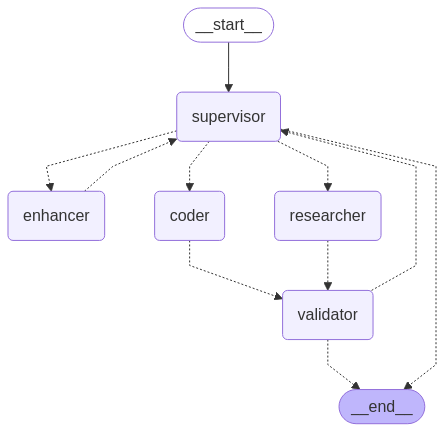

In [11]:
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 


In [12]:
import pprint

inputs = {
    "messages": [
        ("user", "Weather in Chennai"),
    ]
}

for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()
     

--- Transición del Flujo de Trabajo: Supervisor → RESEARCHER ---
"Output from node 'supervisor':"
HumanMessage(content='The user is asking a question about the weather in Chennai which requires gathering information using a researcher to provide an accurate response. ', additional_kwargs={}, response_metadata={}, name='supervisor', id='951d3fca-484d-4707-819a-4aa181b840a7')

--- Workflow Transition: Researcher → Validator ---
"Output from node 'researcher':"
HumanMessage(content='The weather in Chennai is currently clear with a temperature of 31.1°C (88.0°F). The wind is blowing from the SSW at 19.1 kph. The humidity is 84%. The forecast for today is Haze with a maximum temperature of 36°C and a minimum of 29°C.', additional_kwargs={}, response_metadata={}, name='researcher', id='7952ccd1-d55f-4513-9cf7-d56846bb56ca')

 --- Transitioning to END ---
"Output from node 'validator':"
HumanMessage(content="The answer provides the weather in Chennai, which addresses the user's question. It i

In [13]:
import pprint

inputs = {
    "messages": [
        ("user", "Give me the 20th fibonacci number"),
    ]
}
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()
     

--- Transición del Flujo de Trabajo: Supervisor → CODER ---
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user is asking for a specific calculation, which falls under the coder's expertise. The coder will calculate the 20th Fibonacci number and provide it to the user, fulfilling the request directly and efficiently. No further clarification or research is needed at this point. ", additional_kwargs={}, response_metadata={}, name='supervisor', id='5d007b87-e180-4686-9c75-e354f7c81faa')]}

--- Workflow Transition: Coder → Validator ---
"Output from node 'coder':"
{ 'messages': [ HumanMessage(content='The 20th Fibonacci number is 6765.', additional_kwargs={}, response_metadata={}, name='coder', id='d87b8f14-bc2a-4ccb-8dc7-331b66a1110a')]}

 --- Transitioning to END ---
"Output from node 'validator':"
{ 'messages': [ HumanMessage(content="The answer is correct and addresses the user's request", additional_kwargs={}, response_metadata={}, name='validator', id='00